In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
root_dir = Path('..').resolve()
data_dir = root_dir / 'data'
dementia_dir = data_dir / 'dementia-net' / 'dementia'
nodementia_dir = data_dir / 'dementia-net' / 'nodementia'
processed_dir = data_dir / 'processed'

os.makedirs(processed_dir, exist_ok=True)
os.makedirs(processed_dir / 'train' / 'dementia', exist_ok=True)
os.makedirs(processed_dir / 'train' / 'nodementia', exist_ok=True)
os.makedirs(processed_dir / 'validation' / 'dementia', exist_ok=True)
os.makedirs(processed_dir / 'validation' / 'nodementia', exist_ok=True)
os.makedirs(processed_dir / 'test' / 'dementia', exist_ok=True)
os.makedirs(processed_dir / 'test' / 'nodementia', exist_ok=True)

print(f"Paths set up. Root directory: {root_dir}")
print(f"Dementia directory: {dementia_dir}")
print(f"No dementia directory: {nodementia_dir}")
print(f"Processed directory: {processed_dir}")

Paths set up. Root directory: D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml
Dementia directory: D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\data\dementia-net\dementia
No dementia directory: D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\data\dementia-net\nodementia
Processed directory: D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\data\processed


In [3]:
# Function to preprocess audio
def preprocess_audio(audio_path, output_path=None):
    """Preprocess audio according to project specifications"""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        
        # Convert to mono if stereo
        if len(y.shape) > 1:
            y = librosa.to_mono(y)
        
        # Resample to target sampling rate
        target_sr = 16000  # Specified in training.json as target_sampling_rate
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        
        # Normalize audio
        y = librosa.util.normalize(y)
        
        # Trim silence
        y, _ = librosa.effects.trim(y)
        
        # Check if audio is too long and truncate if necessary
        max_length_seconds = 10  # Specified in training.json
        max_samples = int(max_length_seconds * target_sr)
        if len(y) > max_samples:
            y = y[:max_samples]
        
        # Save processed audio
        if output_path:
            sf.write(output_path, y, target_sr, format='WAV')
        
        return y, target_sr
    except Exception as e:
        print(f"Error preprocessing {audio_path}: {str(e)}")
        return None, None

In [4]:
# Create dataframe of all audio files with metadata
def create_audio_dataframe():
    data = []
    
    # Process dementia samples
    if dementia_dir.exists():
        print(f"Scanning dementia files in {dementia_dir}")
        # Walk through all subdirectories
        for root, dirs, files in os.walk(dementia_dir):
            for file in files:
                if file.lower().endswith('.wav'):
                    # Get the full path to the file
                    full_path = Path(root) / file
                    
                    # Extract speaker ID from the folder name 
                    # (assuming the immediate parent directory is the speaker name)
                    speaker_id = Path(root).name
                    
                    # Try to extract years to onset from filename if it follows pattern
                    years_to_onset = None
                    if '_' in file:
                        parts = file.split('_')
                        if len(parts) > 1:
                            try:
                                # Attempt to extract number after underscore and before .wav
                                number_part = parts[1].split('.')[0]
                                # Some filenames have additional info like "5_1" - take just the first number
                                years_to_onset = int(number_part.split('_')[0])
                            except (ValueError, IndexError):
                                pass
                    
                    data.append({
                        'file_path': str(full_path),
                        'speaker_id': speaker_id,
                        'label': 1,  # 1 for dementia
                        'years_to_onset': years_to_onset,
                        'file_name': file
                    })
    else:
        print(f"Warning: Dementia directory {dementia_dir} does not exist")
    
    # Process non-dementia samples
    if nodementia_dir.exists():
        print(f"Scanning non-dementia files in {nodementia_dir}")
        # Walk through all subdirectories
        for root, dirs, files in os.walk(nodementia_dir):
            for file in files:
                if file.lower().endswith('.wav'):
                    # Get the full path to the file
                    full_path = Path(root) / file
                    
                    # Extract speaker ID from the folder name
                    speaker_id = Path(root).name
                    
                    # Try to extract age bucket from filename (1, 2, 3 corresponding to age ranges)
                    sample_age_bucket = None
                    if '_' in file:
                        parts = file.split('_')
                        if len(parts) > 1:
                            try:
                                # Attempt to extract number after underscore and before .wav
                                age_part = parts[1].split('.')[0]
                                sample_age_bucket = int(age_part)
                            except (ValueError, IndexError):
                                pass
                    
                    data.append({
                        'file_path': str(full_path),
                        'speaker_id': speaker_id,
                        'label': 0,  # 0 for no dementia
                        'years_to_onset': None,
                        'sample_age_bucket': sample_age_bucket,  # Adding age bucket for no-dementia samples
                        'file_name': file
                    })
    else:
        print(f"Warning: No-dementia directory {nodementia_dir} does not exist")
    
    return pd.DataFrame(data)

In [5]:
def split_data(df):
    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1
    
    # First split: train vs (val+test)
    temp_ratio = val_ratio + test_ratio
    gss1 = GroupShuffleSplit(n_splits=1, test_size=temp_ratio, random_state=42)
    train_idx, temp_idx = next(gss1.split(df, groups=df['speaker_id']))
    
    train_df = df.iloc[train_idx].reset_index(drop=True)
    temp_df = df.iloc[temp_idx].reset_index(drop=True)
    
    # Second split: val vs test from temp
    val_test_ratio = val_ratio / temp_ratio
    gss2 = GroupShuffleSplit(n_splits=1, test_size=(1-val_test_ratio), random_state=42)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df['speaker_id']))
    
    val_df = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)
    
    return train_df, val_df, test_df

In [6]:
def save_enhanced_metadata(train_df, val_df, test_df):
    # Calculate additional statistics for YTD distribution
    for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
        # Create a summary file with speaker-level statistics
        speaker_stats = []
        for speaker, group in df.groupby('speaker_id'):
            speaker_stats.append({
                'speaker_id': speaker,
                'num_samples': len(group),
                'has_dementia': int(group['label'].iloc[0]),
                'min_years_to_onset': group['years_to_onset'].min() if not group['years_to_onset'].isna().all() else None,
                'max_years_to_onset': group['years_to_onset'].max() if not group['years_to_onset'].isna().all() else None
            })
        
        pd.DataFrame(speaker_stats).to_csv(processed_dir / f'{name}_speaker_stats.csv', index=False)
    
    # Create a special regression dataset file for years to onset prediction
    ytd_df = audio_df[audio_df['label'] == 1].copy()
    ytd_df = ytd_df[~ytd_df['years_to_onset'].isna()].copy()
    
    if not ytd_df.empty:
        # Create a file mapping filenames to years-to-onset for regression tasks
        ytd_mapping = ytd_df[['file_name', 'years_to_onset', 'speaker_id']]
        ytd_mapping.to_csv(processed_dir / 'years_to_onset_regression.csv', index=False)
        
        # Visualize the years-to-onset distribution
        plt.figure(figsize=(10, 6))
        plt.hist(ytd_df['years_to_onset'], bins=range(0, 16), alpha=0.7)
        plt.xlabel('Years to Onset')
        plt.ylabel('Number of Samples')
        plt.title('Distribution of Years to Onset in Dementia Samples')
        plt.grid(True, alpha=0.3)
        plt.savefig(processed_dir / 'years_to_onset_distribution.png')
        plt.show()

In [7]:
# Process and copy files to appropriate directories
def process_and_distribute_files(df, split_name):
    processed_count = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name} files"):
        label_dir = 'dementia' if row['label'] == 1 else 'nodementia'
        output_path = processed_dir / split_name / label_dir / row['file_name']
        
        if preprocess_audio(row['file_path'], output_path)[0] is not None:
            processed_count += 1
    
    print(f"Successfully processed {processed_count}/{len(df)} files for {split_name} split")

Creating audio dataframe...
Scanning dementia files in D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\data\dementia-net\dementia
Scanning non-dementia files in D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\data\dementia-net\nodementia
Found 455 audio files (131 dementia, 324 no dementia)
Splitting data into train/validation/test sets (80/10/10 split)...
Train set: 359 files, 172 speakers
Validation set: 45 files, 21 speakers
Test set: 51 files, 22 speakers


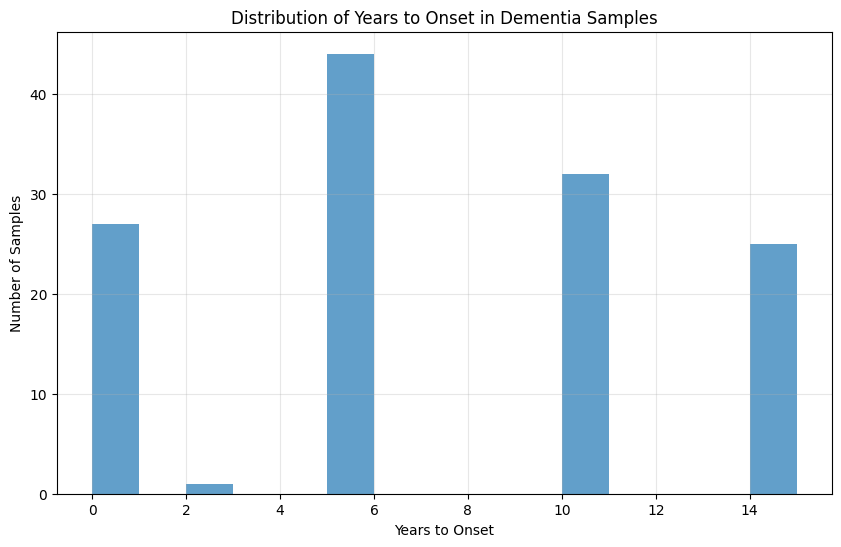


Class distribution:
Train: Dementia=110, No Dementia=249
Validation: Dementia=10, No Dementia=35
Test: Dementia=11, No Dementia=40


<Figure size 1000x600 with 0 Axes>

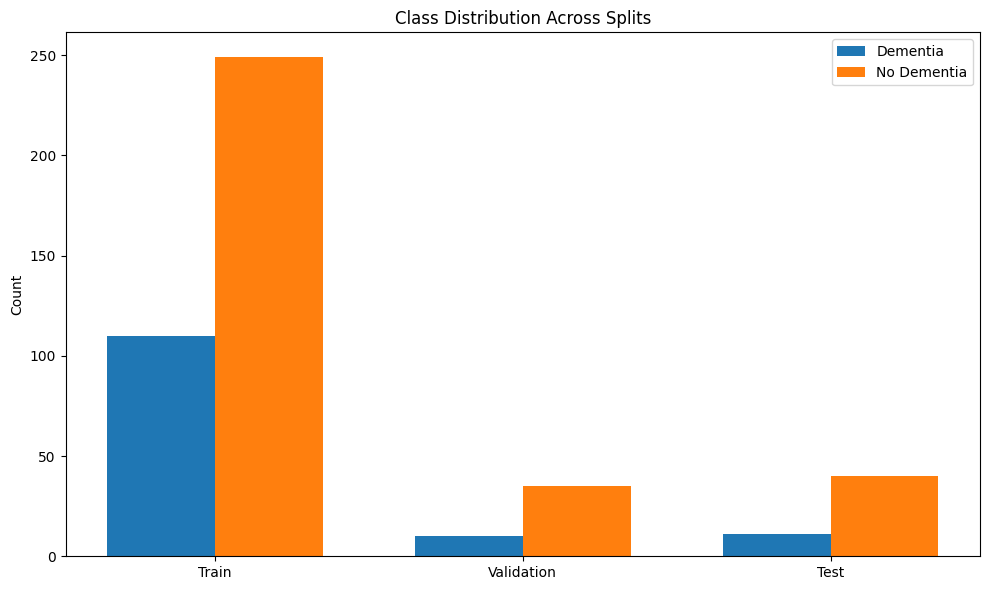


Years to onset data: 129/131 dementia samples have years-to-onset data
Range: 0.0 to 15.0 years

Processing and distributing files...


Processing train files: 100%|█| 


Successfully processed 359/359 files for train split


Processing validation files: 100


Successfully processed 45/45 files for validation split


Processing test files: 100%|█| 5

Successfully processed 51/51 files for test split
Data preparation completed!


In [8]:
print("Creating audio dataframe...")
audio_df = create_audio_dataframe()

if audio_df.empty:
    print("No audio files found in the specified directories.")
else:
    print(f"Found {len(audio_df)} audio files ({audio_df['label'].sum()} dementia, {len(audio_df)-audio_df['label'].sum()} no dementia)")
    
    print("Splitting data into train/validation/test sets (80/10/10 split)...")
    train_df, val_df, test_df = split_data(audio_df)
    
    print(f"Train set: {len(train_df)} files, {train_df['speaker_id'].nunique()} speakers")
    print(f"Validation set: {len(val_df)} files, {val_df['speaker_id'].nunique()} speakers")
    print(f"Test set: {len(test_df)} files, {test_df['speaker_id'].nunique()} speakers")
    
    # Save splits for future reference
    train_df.to_csv(processed_dir / 'train_metadata.csv', index=False)
    val_df.to_csv(processed_dir / 'val_metadata.csv', index=False)
    test_df.to_csv(processed_dir / 'test_metadata.csv', index=False)
    
    # Create enhanced metadata and visualizations
    save_enhanced_metadata(train_df, val_df, test_df)
    
    # Analyze class distribution
    print("\nClass distribution:")
    for split, df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        print(f"{split}: Dementia={df['label'].sum()}, No Dementia={len(df)-df['label'].sum()}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    splits = ['Train', 'Validation', 'Test']
    dementia_counts = [train_df['label'].sum(), val_df['label'].sum(), test_df['label'].sum()]
    no_dementia_counts = [len(train_df)-train_df['label'].sum(), 
                          len(val_df)-val_df['label'].sum(), 
                          len(test_df)-test_df['label'].sum()]
    
    x = np.arange(len(splits))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, dementia_counts, width, label='Dementia')
    ax.bar(x + width/2, no_dementia_counts, width, label='No Dementia')
    
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution Across Splits')
    ax.set_xticks(x)
    ax.set_xticklabels(splits)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(processed_dir / 'class_distribution.png')
    plt.show()
    
    # Check the years to onset data distribution
    dementia_with_ytd = audio_df[(audio_df['label'] == 1) & (~audio_df['years_to_onset'].isna())]
    if not dementia_with_ytd.empty:
        print(f"\nYears to onset data: {len(dementia_with_ytd)}/{audio_df['label'].sum()} dementia samples have years-to-onset data")
        print(f"Range: {dementia_with_ytd['years_to_onset'].min()} to {dementia_with_ytd['years_to_onset'].max()} years")
    
    process_files = True
    if process_files:
        print("\nProcessing and distributing files...")
        process_and_distribute_files(train_df, 'train')
        process_and_distribute_files(val_df, 'validation')
        process_and_distribute_files(test_df, 'test')
        print("Data preparation completed!")
    else:
        print("File processing skipped.")